<a href="https://colab.research.google.com/github/CagataySencan/TrafficSignRecognition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import  PIL
from PIL import  ImageEnhance , ImageOps , Image
from matplotlib import pyplot
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sn 


In [ ]:
# Verisetini Kaggle'dan çekmek için gerekli kurulumlar

! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Verisetini Google Colab'e ekleme işlemi

! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
! unzip gtsrb-german-traffic-sign.zip

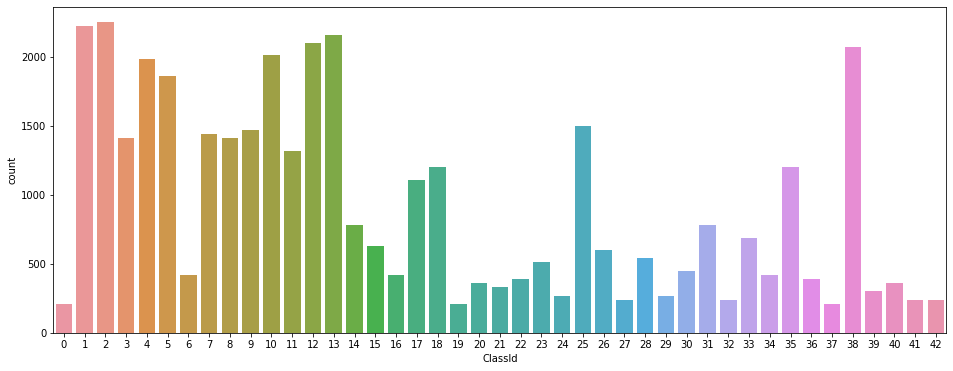

In [58]:
# Veri Önişleme aşamaları

trainDatas = pd.read_csv('Train.csv')
testDatas = pd.read_csv('Test.csv')
metaDatas = pd.read_csv('Meta.csv')
# Class sayısı
classCount = len(trainDatas['ClassId'].value_counts())
# Classların başlıklarının tanımlanması 
classes = { 0:'Hız Limiti (20km/s)',
            1:'Hız Limiti (30km/s)', 
            2:'Hız Limiti (50km/s)', 
            3:'Hız Limiti (60km/s)', 
            4:'Hız Limiti (70km/s)', 
            5:'Hız Limiti (80km/s)', 
            6:'Hız Limitinin bitişi (80km/s)', 
            7:'Hız Limiti (100km/s)', 
            8:'Hız Limiti (120km/s)', 
            9:'Geçiş yok', 
            10:'Ağırlığı 3.5 ton üstü olan araçlar geçemez', 
            11:'Kavşakta geçiş hakkı', 
            12:'Öncelikli yol', 
            13:'Yol ver', 
            14:'Dur', 
            15:'Araç giremez', 
            16:'3.5 Ton üzeri araçlar yasak', 
            17:'Giriş yok', 
            18:'Genel uyarı', 
            19:'Sola tehlikeli viraj', 
            20:'Sağa tehlikeli viraj', 
            21:'Sağa tehlikeli devamlı virajlar', 
            22:'Engebeli yol', 
            23:'Kaygan yol', 
            24:'Sağdan daralan yol', 
            25:'Yol çalışması', 
            26:'Trafik işaretleri', 
            27:'Yaya geçidi', 
            28:'Okul geçidi', 
            29:'Bisiklet yolu', 
            30:'Buzlanmaya dikkat',
            31:'Vahşi hayvan çıkabilir', 
            32:'Hız sınırı sonu', 
            33:'Sadece sağa dönüş var', 
            34:'Sadece sola dönüş var', 
            35:'Dönüş yok', 
            36:'Sola dönüş yok', 
            37:'Sağa dönüş yok', 
            38:'Sağdan gidin', 
            39:'Soldan gidin', 
            40:'Dönüş önceliği', 
            41:'Geçiş olmayan yolun sonu', 
            42:'3.5 Ton üzeri araçlar girebilir' }
# Veri dağılımına bakalım 
plt.figure(figsize=(16,6))
sn.countplot(x=trainDatas['ClassId'])

In [50]:
# Eksik veri kontrolü
print("-Eğitim verisi-\n",trainDatas.isnull().sum(),"\n-------------\n","-Test Verisi-\n",testDatas.isnull().sum())
# Eksik veri bulunamadı

# Uyumsuz veri kontrolü, .png ile bitmeyen bir görüntüye sahip olan satır verisetinden çıkarılacak
for i in trainDatas['Path'] : 
  if i.endswith('.png') == False :
    trainDatas.drop(i.index)
    print(i,". satır siliniyor")

for i in testDatas['Path'] :
  if i.endswith('.png') == False:
    testDatas.drop(i.index)
    print(i,". satır siliniyor")

-Eğitim verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64 
-------------
 -Test Verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


In [48]:
# Eğitim verimizin validation ve eğitim kısmına bölünmesi
X_Train, X_Validate = train_test_split(trainDatas,test_size=0.3,random_state=42)
# Yeni DataFrame oluşturmak için indexleri resetliyoruz
X_Train = X_Train.reset_index(drop = True)
X_Validate = X_Validate.reset_index(drop = True)
batchSize=30
print(X_Train.shape,X_Validate.shape)
# Validation ve eğitim için veriler bölündü

(27446, 8) (11763, 8)


In [63]:
# Augmentation işlemi
# Realtime augmentation yapıldığı için gözle görülür bir artış olmamakla beraber trainGenerator objesini  eğitimde kullanacağımızda bizim için augmentation yapacak
trainGen = ImageDataGenerator(rotation_range=15,width_shift_range=0.2,height_shift_range=0.2,rescale=1./255,horizontal_flip=True)
trainGenerator = trainGen.flow_from_dataframe(X_Train,x_col = 'Path',y_col = 'ClassId',target_size=(120,120),batch_size=batchSize,class_mode='raw')


validateGen = ImageDataGenerator(rescale=1./255)
validateGenerator = validateGen.flow_from_dataframe(X_Validate,x_col='Path',y_col='ClassId',target_size=(120,120),batch_size=batchSize, class_mode='raw')

testGen = ImageDataGenerator(rescale=1./255)
testGenerator=testGen.flow_from_dataframe(testDatas,x_col='Path',y_col=None,target_size=(120,120),batch_size=15,class_mode=None)

Found 27446 validated image filenames.
<class 'keras.preprocessing.image.DataFrameIterator'>
Found 11763 validated image filenames.
Found 12630 validated image filenames.
